In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
from scipy.signal import periodogram
from warnings import simplefilter



input_train = pd.read_csv('x_train.csv')
output_train = pd.read_csv('y_train.csv')
output_train[['date', 'station']] = output_train['index'].str.split('_', expand=True)
#output_train.drop(columns=['index'], inplace=True)#Inclusion du nom des stations
y_copy= output_train.copy()
output_train = output_train[['date', 'station', 'y']]
input_train.head()
output_train.head
X = input_train
y=output_train

Hypothèse n°1 : L'année n'a que peu d'incidence, on va décider de supprimer cette entrée pour garder seulement le reste et faire une première régression "naïve" là-dessus. Pour cela, on va créer une catégorie "année", "mois" et "jour" puis drop la colonne des années.

En réalité ce n'est pas le cas, on ne va pas la drop...

In [2]:
input_train['date'] = pd.to_datetime(input_train['date'])

input_train['année'] = input_train['date'].dt.year-2014
input_train['mois'] = input_train['date'].dt.month
input_train['jour'] = input_train['date'].dt.day

#X = input_train.drop(columns=['année','date'],axis=1)
X = input_train.drop(columns=['date'],axis=1)
output_train['date'] = pd.to_datetime(output_train['date'])

# output_train['année'] = output_train['date'].dt.year
# output_train['mois'] = output_train['date'].dt.month
# output_train['jour'] = output_train['date'].dt.day



X.head()

,station,job,ferie,vacances,année,mois,jour
0,1J7,1,1,1,1,1,1
1,O2O,1,1,1,1,1,1
2,8QR,1,1,1,1,1,1
3,UMC,1,1,1,1,1,1
4,FK3,1,1,1,1,1,1


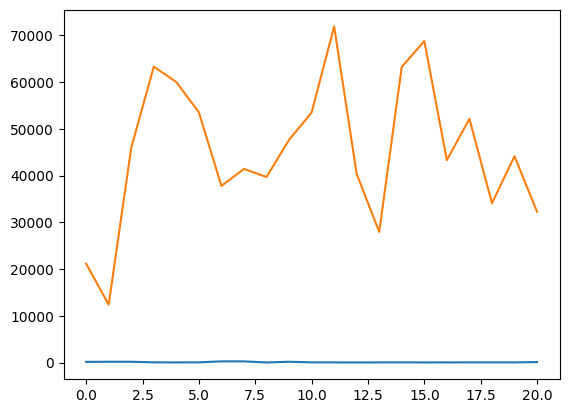

In [3]:
#y = output_train.drop(columns=['année','date'],axis=1)
y.set_index("station",inplace=True)

tab_station= y.loc['1J7']
tab_station_2 = y.loc['M36']
nb_station = []
nb_station_2 = []
for x in tab_station['y']:
    nb_station.append(x)

for x in tab_station_2['y']:
    nb_station_2.append(x)
A = np.arange(0,len(tab_station['y']))
plt.plot(A[0:21],nb_station[60:60+21],nb_station_2[60:60+21])

def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)




On voit qu'il y a une sorte d'influence liée aux semaines, on va essayer de plot ca un peu plus clairement avec un périodigramme

In [4]:
simplefilter("ignore")
# IMPORTE DE KAGGLE - COURS SUR LES TIMESERIES

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

,date,y
station,,
M36,2015-01-01,15190
M36,2015-02-01,27710
M36,2015-03-01,22145
M36,2015-04-01,54765
M36,2015-05-01,22421


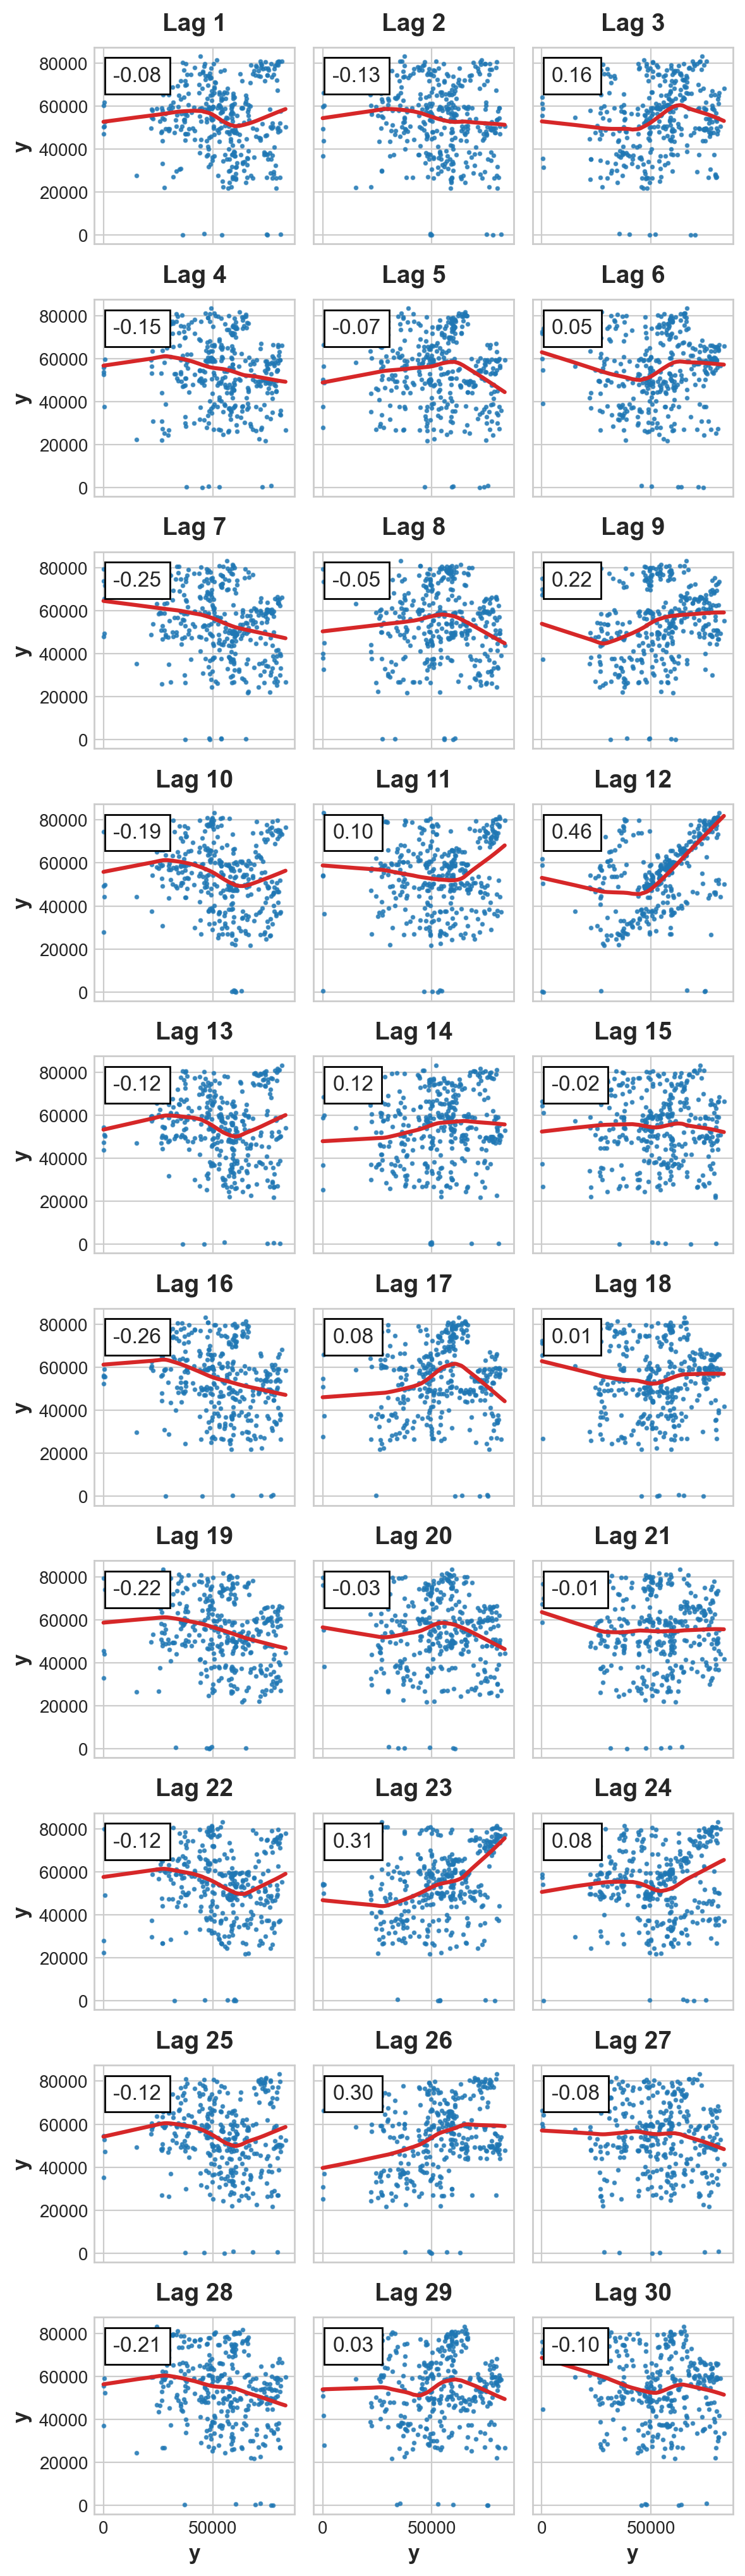

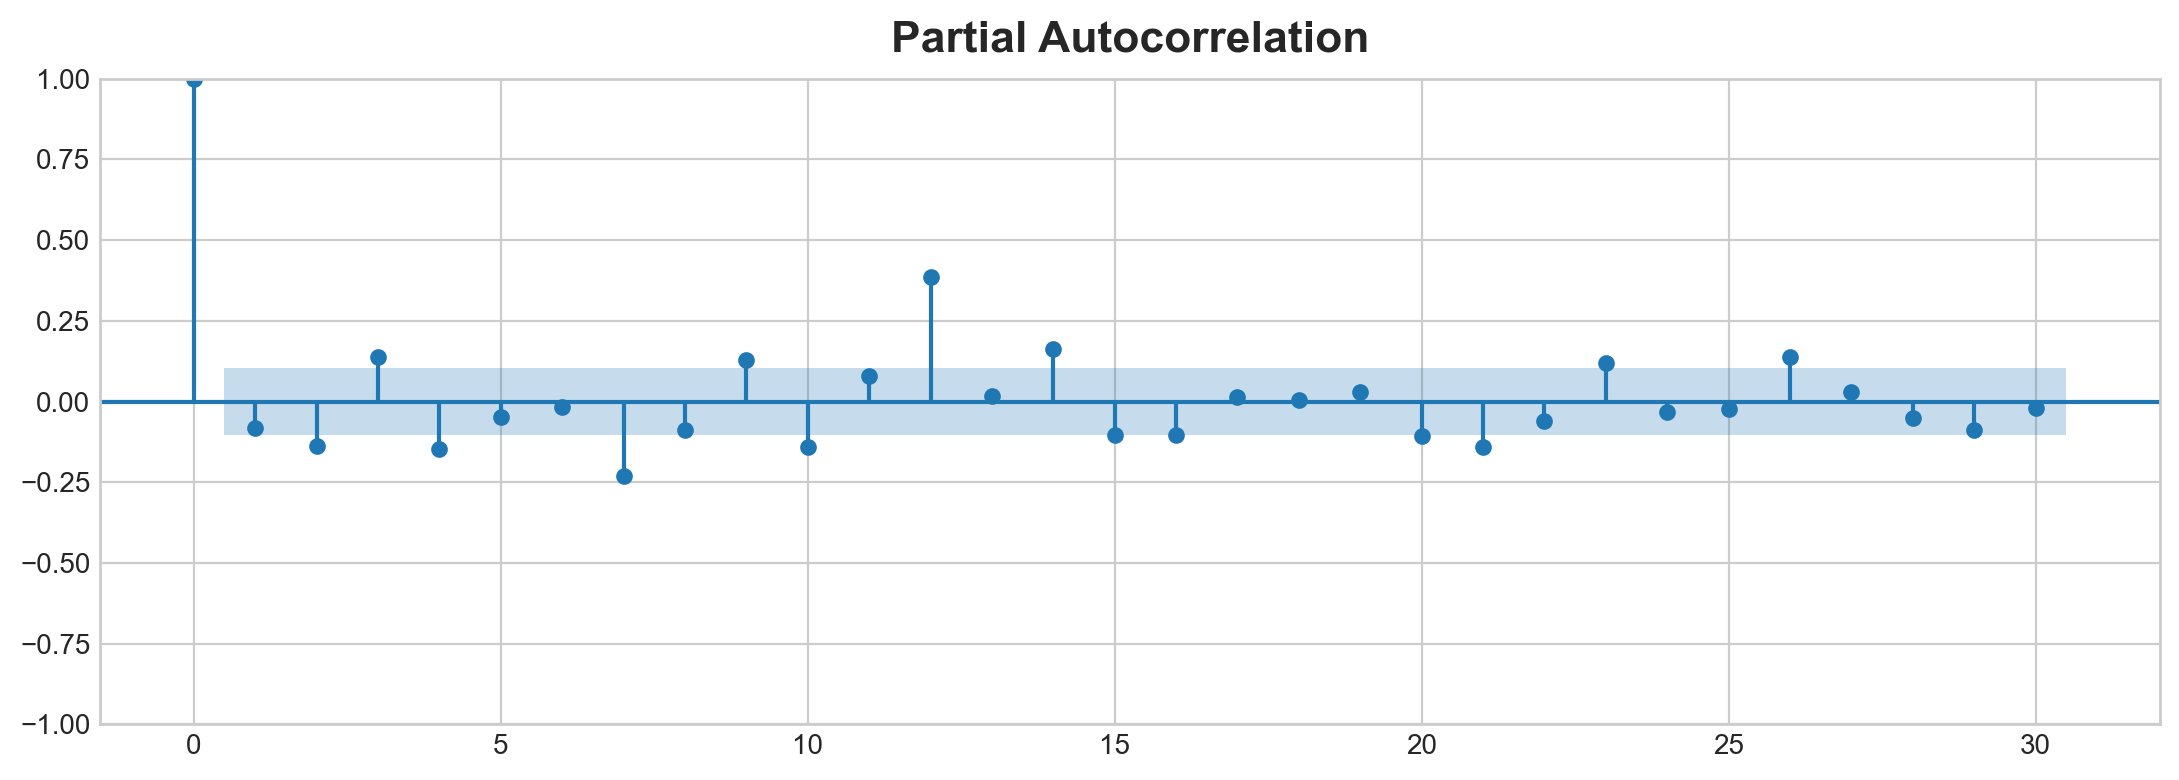

In [5]:
# Convertir la colonne 'Date' en format datetime si elle n'est pas déjà en format datetime
tab_station_2['date'] = pd.to_datetime(tab_station_2['date'])

# Filtrer les données pour supprimer toutes les dates correspondant à l'année 2016
tab_station_2f = tab_station_2[~tab_station_2['date'].dt.year.isin([2016,2017,2018,2019,2020,2021,2022,2023])]

_ = plot_lags(tab_station_2f.y, lags=30, nrows=10)
_ = plot_pacf(tab_station_2f.y, lags=30)
tab_station_2f.head()

On observe un lag de 12, très utile pour la suite on va retenir celui-ci pour nos futurs modèles
Reste à voir la saisonnalité.

<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

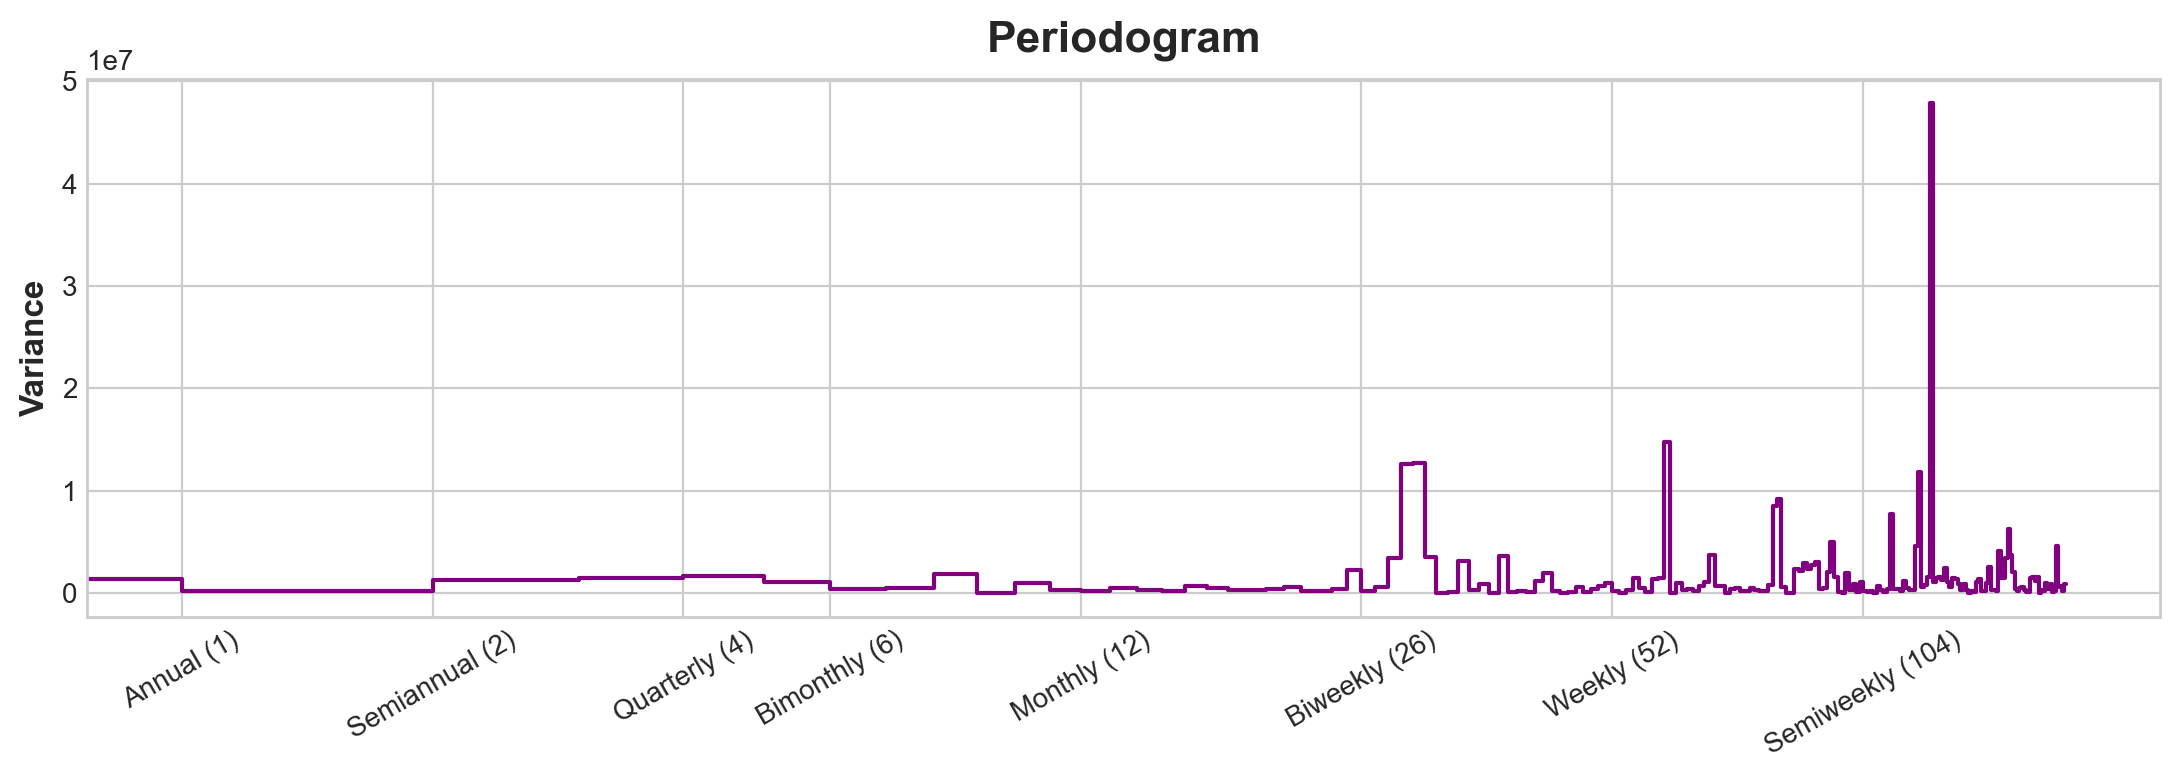

In [120]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from style import *  # plot style settings
from utils import plot_periodogram, seasonal_plot
plot_periodogram(tab_station_2f.y)

In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder #on va preprocess les stations pour leur donner des numéros

y = y_copy.drop(['index'],axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)





In [122]:
y_train.head()

,y,date,station
887872,32,2018-12-22,NEB
1137273,8239,2018-03-29,MIH
945947,524,2020-05-24,H2L
28471,411,2019-09-01,9WY
321508,10150,2017-12-08,294


In [123]:
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)
# Apply one-hot encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
ordinal_X_train = pd.DataFrame(ordinal_encoder.fit_transform(X_train[object_cols]))
ordinal_X_test = pd.DataFrame(ordinal_encoder.transform(X_test[object_cols]))
ordinal_y_train = pd.DataFrame(ordinal_encoder.transform(y_train[object_cols]))
X_train['station'] = ordinal_X_train
y_train[object_cols] = ordinal_y_train

#X_train.head()
X_train.head()

['station']


,station,job,ferie,vacances,année,mois,jour
887872,298.0,0,0,1,4,12,22
1137273,NaN,1,0,0,4,3,29
945947,231.0,0,0,1,6,5,24
28471,327.0,0,0,1,5,9,1
321508,179.0,1,0,0,3,12,8


In [124]:
y_train.head()

,y,date,station
887872,32,2018-12-22,298.0
1137273,8239,2018-03-29,NaN
945947,524,2020-05-24,231.0
28471,411,2019-09-01,327.0
321508,10150,2017-12-08,179.0
